# Gaussian Mixture Model using Expectation Maximization algorithm



*   Regarding each point as being generated by a *mixture of Gaussians* and compute that probability

$$ p(x)=\sum_{j=1}^{k}{\pi_{j}\mathcal{N}(x;\mu_j,\Sigma_j)} $$
$$ \left(\sum_{j=1}^{k}{\pi_j}=1\right)$$



*   A particular data point $x$ is a linear combination of the $k$ Gaussians, weighting each Gaussian with $\phi_j$, which represents the strenth of that Gaussian.
*   Need to write update: $\pi_j, \mu_j, \Sigma_j$

Then, how do we learn the parameters?


---

## Expectation-Maximization (EM) algorithm



*   **Expectation step**: compute the probability that each data point $x^{(i)}$ was generated by Gaussian $j$. (soft assignments)

$$ \gamma_j^{(i)}=\dfrac{\pi_{j}\mathcal{N}(x^{(i)}; \mu_j, \Sigma_j)}{\sum_{q=1}^{k}{\pi_{q}}\mathcal{N}(x^{(i)}; \mu_q, \Sigma_q)} $$

*   **Maximization step**: update the weights, means, and covariances

$$ \pi_{j}=\frac{1}{N}\sum_{i=1}^{N}{\gamma_{j}^{(i)}}\text{(Responsibility)}$$ 
$$ \mu_{j}=\dfrac{\sum_{i=1}^{N}{\gamma_{j}^{(i)}}x^{(i)}}{\sum_{i=1}^{N}{\gamma_{j}^{(i)}}}$$
$$ \Sigma_{j}=\dfrac{\sum_{i=1}^{N}{\gamma_{j}^{(i)}}(x^{(i)}-\mu_{j})(x^{(i)}-\mu_j)^\top}{\sum_{i=1}^{N}{\gamma_{j}^{(i)}}}$$


---

The probability density function (pdf) of a multivariate normal is
$$f(x)=\frac{1}{\sqrt{(2\pi)^{k}|\Sigma|}}\exp{\left(-\frac{1}{2}(x-\mu)^{\top}\Sigma^{-1}(x-\mu)\right)}$$









In [0]:
from collections import namedtuple  # All parameters from fitting/learning are kept in a named tuple
from matplotlib.patches import Ellipse

import numpy as np
import pylab as plt

In [0]:
class GMM:
    
    def __init__(self, k=2, eps=0.0001):
        
        self.k = k  # number of clusters
        self.eps = eps  # threshold to stop('epsilon')
        
      
    def fit_EM(self, X, max_iters=1000):
      
        n, d = X.shape  # n=number of data points, d=dimension of datapoints
        
        ## randomly choose the starting centroids/means
        mu = X[np.random.choice(n, self.k, False), :]
        
        
        ## initialize the covariance matrices for each gaussian
        sigma = [np.eye(d)] * self.k
        
        ## initialize the probabilities/weights for each gaussian
        w = [1./self.k] * self.k
    
        ## responsibility matrix is initialized to all zeros
        R = np.zeros((n, self.k))  # n points for each of k gaussians
        
        ## log-likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 * (2*np.pi) ** (-X.shape[1]/2.)\
                * np.exp(-.5 * np.einsum('ij, ij -> i', \
                X-mu, np.dot(np.linalg.inv(s), (X-mu).T).T))
        
        
        ## iterate till max iterations
        while len(log_likelihoods) < max_iters:
        
            ## E step
            ## vectorized implementation of E step equation
            ## to calculate the membership for each of k-gaussians
            
            for k in range(self.k):
                R[:,k] = w[k] * P(mu[k], sigma[k])
                
            ## likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis=1)))
            log_likelihoods.append(log_likelihood)
            
            ## normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis=1)).T
            
            N_ks = np.sum(R, axis=0)  # number of datapoints belonging to each gaussian
            
            
            ## M step
            ## calculate the new mean and covariance for each gaussian
            ## by utilizing the new responsibilities
            
            for k in range(self.k):
              
                ## probabilities
                w[k] = (1. / n) * N_ks[k]
              
                ## means
                mu[k] = (1. / N_ks[k]) * np.sum(R[:,k] * X.T, axis=1).T
                
                ## covariances
                x_mu = np.matrix(X-mu[k])
                sigma[k] = np.array( (1 / N_ks[k]) * np.dot(np.multiply(x_mu.T, R[:,k]), x_mu) )
                
            
            ## check for convergence
            if len(log_likelihoods) < 2:
                continue
                
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps:
                break
                
        ## bind all results together
        self.params = namedtuple('params', ['mu', 'sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.sigma = sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)
        
        return self.params
      
          
    def predict(self, x):
      
        p = lambda mu, s: np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x-mu, \
                         np.dot(np.linalg.inv(s), x-mu)))
        
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.sigma, self.params.w)])
        
        return probs / np.sum(probs)  
      
      
    def plot_log_likelihood(self):
      
        plt.plot(self.params.log_likelihoods)
        plt.title('Log-likelihood vs Iteration Plot')
        plt.xlabel('Iterations')
        plt.ylabel('Log-likelihood')
        plt.show()

In [0]:
def log_likelihood(x, mu, s):
    p = np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x-mu, \
                         np.dot(np.linalg.inv(s), x-mu)))
    return p

In [0]:
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
        
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    ## width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)

    return ellip

In [0]:
def show(X, mu, cov):
      
    plt.cla() 
    K = len(mu)  # number of clusters
    colors = ['b', 'k', 'g', 'c', 'm', 'y', 'r']
    plt.plot(X.T[0], X.T[1], 'm*')

    for k in range(K):
        plot_ellipse(mu[k], cov[k], alpha=0.6, color=colors[k % len(colors)])

## Clustering with Gaussian Mixture Models

Using an algorithm such as K-Means leads to **hard assignments**, meaning that each point is definitively assigned a cluster center. 



*   What if the true clusters actually overlap? 
*   What about data that is more spread out; how do we assign clusters then?






In [0]:
## generate the random data

m1, cov1 = [8,8], [[2,.25], [.25,1]]  # first gaussian
data1 = np.random.multivariate_normal(m1, cov1, 90)

m2, cov2 = [8,9], [[1,-.5], [-.5,2]]  # second gaussian
data2 = np.random.multivariate_normal(m2, cov2, 45)


X_train = np.vstack((data1, data2))
np.random.shuffle(X_train)

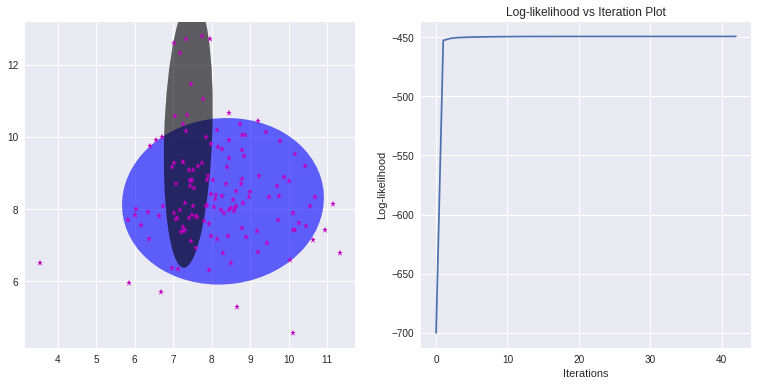

[1.00000000e+00 8.62214552e-78]


In [161]:
gmm = GMM(2, 0.000001)
params = gmm.fit_EM(X_train, max_iters=100)
# print params.log_likelihoods

fig = plt.figure(figsize = (13,6))
fig.add_subplot(121)
show(X_train, params.mu, params.sigma)
fig.add_subplot(122)
gmm.plot_log_likelihood()

print gmm.predict(np.array([1, 2]))

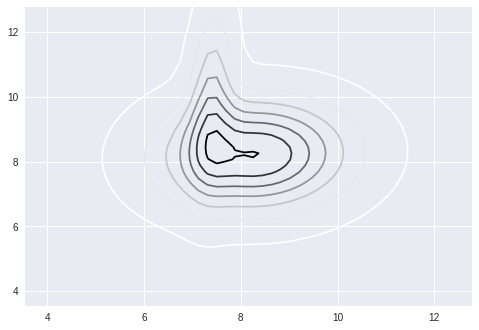

In [162]:
gmm = GMM(2, 0.000001)
params = gmm.fit_EM(X_train, max_iters=100)


X, Y = np.meshgrid(np.linspace(np.min(X_train),np.max(X_train)), np.linspace(np.min(X_train),np.max(X_train)))
XX = np.array([X.ravel(), Y.ravel()]).T

Z = np.zeros((xx.shape[0], 1))
for i in range(XX.shape[0]):
  for j in range(2):
    Z[i] += np.exp(log_likelihood(XX[i], params.mu[j], params.sigma[j]))*params.w[j]

Z = Z.reshape((50,50))
 
plt.contour(X, Y, Z)
# plt.scatter(X_train[:, 0], X_train[:, 1])
 
# plt.show()

In [142]:
params.mu

array([[2.91356459, 2.98953986],
       [1.60641072, 1.2916035 ]])

In [143]:
params.sigma

[array([[0.97152175, 0.49455514],
        [0.49455514, 0.83308881]]), array([[ 0.78966199, -0.56197681],
        [-0.56197681,  0.74976619]])]

In [144]:
params

__main__.params

In [134]:
log_likelihood(params.mu[i], params.sigma[0])

ValueError: ignored

In [145]:
params.w

[0.5718718071196043, 0.4281281928803958]